In [1]:
import numpy as np
import torch
import os, sys

project_root = os.path.abspath("..")
src_root = os.path.join(project_root, "src")

sys.path = [p for p in sys.path if p not in (project_root, src_root)]

sys.path.insert(0, project_root)
sys.path.insert(1, src_root)


if "src" in sys.modules:
    del sys.modules["src"]

import src

import src

from src.utils import set_seed, get_device
from src.data import load_har, make_train_val_test, make_dataloaders
from src.models import LRBaseline, SmallCNN, MLPHar
from src.train import train_classifier, evaluate_classifier

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

eps_list = [0.2, 0.5, 1.0, 2.0, 4.0]

acc_by_eps = {}

for eps in eps_list:
    print(f"== ε = {eps} ==")

    # 1. Load pre-noised LDP features
    data = np.load(f"../outputs/har_ldp_qbox_eps{eps}.npz")

    X = data["X"]
    y = data["y"]
    user_ids = data["user_ids"]

    # 2. Subject-wise split (train/val/test)
    unique_users = np.unique(user_ids)

    # standard 70/15/15 split by subject ID
    train_users, temp_users = train_test_split(unique_users, test_size=0.30, random_state=42)
    val_users, test_users = train_test_split(temp_users, test_size=0.50, random_state=42)

    def mask(uids): 
        return np.isin(user_ids, uids)

    X_tr, y_tr = X[mask(train_users)], y[mask(train_users)]
    X_val, y_val = X[mask(val_users)], y[mask(val_users)]
    X_te, y_te = X[mask(test_users)], y[mask(test_users)]

    # 3. Build PyTorch dataloaders
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long)

    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)

    X_te_t = torch.tensor(X_te, dtype=torch.float32)
    y_te_t = torch.tensor(y_te, dtype=torch.long)

    train_ds = torch.utils.data.TensorDataset(X_tr_t, y_tr_t)
    val_ds   = torch.utils.data.TensorDataset(X_val_t, y_val_t)
    test_ds  = torch.utils.data.TensorDataset(X_te_t, y_te_t)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=128, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=128, shuffle=False)

    # 4. Train HAR model on LDP features
    model = MLPHar(input_dim=X_tr.shape[1], num_classes=6).to(device)

    history = train_classifier(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=10,
        lr=1e-3,
        preprocess_fn=None,
    )

    # 5. Collect best validation accuracy
    best_acc = max(history["val_acc"])
    acc_by_eps[eps] = best_acc
    print("Best val acc =", best_acc)

acc_by_eps


== ε = 0.2 ==
Epoch 01: train_loss=1.5650, train_acc=0.2738, val_loss=1.4385, val_acc=0.3074
Epoch 02: train_loss=1.2484, train_acc=0.4651, val_loss=1.4717, val_acc=0.3204
Epoch 03: train_loss=0.9985, train_acc=0.6003, val_loss=1.5916, val_acc=0.3145
Epoch 04: train_loss=0.6822, train_acc=0.7497, val_loss=1.8498, val_acc=0.2862
Epoch 05: train_loss=0.3401, train_acc=0.9093, val_loss=2.2315, val_acc=0.3004
Epoch 06: train_loss=0.1065, train_acc=0.9867, val_loss=2.7489, val_acc=0.2915
Epoch 07: train_loss=0.0279, train_acc=0.9998, val_loss=3.0686, val_acc=0.2903
Epoch 08: train_loss=0.0088, train_acc=1.0000, val_loss=3.2534, val_acc=0.2915
Epoch 09: train_loss=0.0049, train_acc=1.0000, val_loss=3.3802, val_acc=0.2962
Epoch 10: train_loss=0.0035, train_acc=1.0000, val_loss=3.4759, val_acc=0.2951
Best val acc = 0.32037691401649
== ε = 0.5 ==
Epoch 01: train_loss=1.2513, train_acc=0.3970, val_loss=1.0679, val_acc=0.4670
Epoch 02: train_loss=0.9649, train_acc=0.5392, val_loss=1.0238, val_acc

{0.2: 0.32037691401649,
 0.5: 0.5129564193168433,
 1.0: 0.7014134275618374,
 2.0: 0.8409893992932862,
 4.0: 0.9069493521790342}

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

def compute_linkage_auc(X, user_ids, max_pairs=20000, seed=0):
    rng = np.random.default_rng(seed)

    N = len(user_ids)
    idx = np.arange(N)

    # Positive pairs: same user
    pos_pairs = []
    for _ in range(max_pairs // 2):
        u = rng.choice(user_ids)
        same_idx = idx[user_ids == u]
        if len(same_idx) < 2:
            continue
        i, j = rng.choice(same_idx, size=2, replace=False)
        pos_pairs.append((i, j))

    # Negative pairs: different user
    neg_pairs = []
    for _ in range(max_pairs // 2):
        i, j = rng.choice(N, size=2, replace=False)
        if user_ids[i] != user_ids[j]:
            neg_pairs.append((i, j))

    pos_pairs = np.array(pos_pairs)
    neg_pairs = np.array(neg_pairs)

    # Compute cosine similarity scores
    sims_pos = np.sum(X[pos_pairs[:,0]] * X[pos_pairs[:,1]], axis=1)
    sims_neg = np.sum(X[neg_pairs[:,0]] * X[neg_pairs[:,1]], axis=1)

    scores = np.concatenate([sims_pos, sims_neg])
    labels = np.concatenate([np.ones(len(sims_pos)), np.zeros(len(sims_neg))])

    auc = roc_auc_score(labels, scores)
    return auc

eps_list = [0.2, 0.5, 1.0, 2.0, 4.0]
auc_by_eps = {}

for eps in eps_list:
    print(f"== ε = {eps} ==")
    data = np.load(f"../outputs/har_ldp_qbox_eps{eps}.npz")
    X = data["X"]
    user_ids = data["user_ids"]

    auc = compute_linkage_auc(X, user_ids, max_pairs=20000)
    auc_by_eps[eps] = auc
    print("AUC =", auc)

auc_by_eps


== ε = 0.2 ==
AUC = 0.4982840113528855
== ε = 0.5 ==
AUC = 0.5007675023651845
== ε = 1.0 ==
AUC = 0.5033031010196574
== ε = 2.0 ==
AUC = 0.5039376484810258
== ε = 4.0 ==
AUC = 0.5044934615788921


{0.2: 0.4982840113528855,
 0.5: 0.5007675023651845,
 1.0: 0.5033031010196574,
 2.0: 0.5039376484810258,
 4.0: 0.5044934615788921}

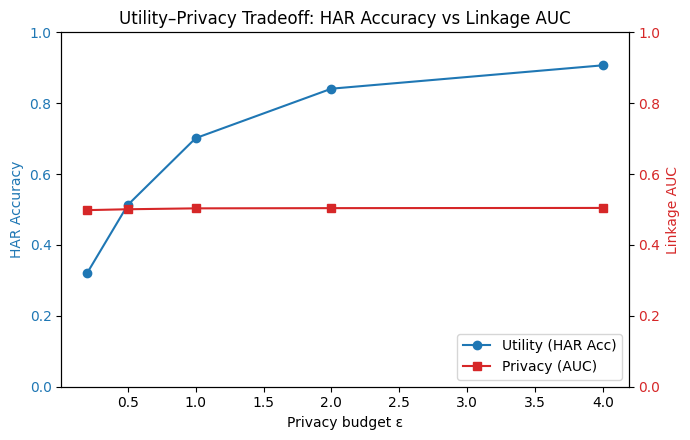

In [ ]:
import matplotlib.pyplot as plt

# Sort epsilons to keep curves aligned
epsilons = sorted(acc_by_eps.keys())

accs = [acc_by_eps[e] for e in epsilons]
aucs = [auc_by_eps[e] for e in epsilons]

fig, ax1 = plt.subplots(figsize=(7, 4.5))

# Utility Curve: Accuracy
ax1.set_xlabel("Privacy budget ε")
ax1.set_ylabel("HAR Accuracy", color="tab:blue")
ax1.plot(epsilons, accs, marker="o", color="tab:blue", label="Utility (HAR Acc)")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 1)

# Privacy Curve: AUC
ax2 = ax1.twinx()
ax2.set_ylabel("Linkage AUC", color="tab:red")
ax2.plot(epsilons, aucs, marker="s", color="tab:red", label="Privacy (AUC)")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0, 1)

# Combined Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

plt.title("Utility–Privacy Tradeoff: HAR Accuracy vs Linkage AUC")
plt.tight_layout()
plt.show()
